In [85]:
from scipy.optimize import root
import numpy as np  # type: ignore
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

---

### Part 1: 

Helper function for doing Gaussian elimination: 

In [86]:
def gauss_p(sa, sb):
    ni, nj = sa.shape
    x = np.zeros(ni)
    if ni != nj:
        print('not rectangular matrix')
        return x
    else:
        n = ni
    if n != sb.shape[0]:
        print('no vector b')
        return x
    a = np.zeros([n, n])
    a[:, :] = sa[:]
    b = np.zeros(n)
    b[:] = sb[:]

    eps = np.finfo(float).eps * np.amax(np.abs(np.diag(a)))
    for j in range(0, n-1):
        if abs(a[j, j]) < eps*1e5:
            if np.amax(np.abs(a[j+1:n, j])) < eps:
                print('zero pivot')
                return x
        loc = np.argmax(np.abs(a[j+1:n, j])) + 1
        if j == 0:
            a[j:j+1+loc:loc, j:] = a[j+loc:: -loc, j:]
            b[j:j+1+loc:loc] = b[j+loc:: -loc]
        else:
            a[j:j+1+loc:loc, j:] = a[j+loc:j-1: -loc, j:]
            b[j:j+1+loc:loc] = b[j+loc:j-1: -loc]
        for i in range(j+1, n):
            p = a[i, j] / a[j, j]
            a[i, j+1:n] -= p * a[j, j+1:n]
            b[i] -= p * b[j]
    for i in range(n-1, -1, -1):
        x[i] = (b[i] - np.sum(a[i, i+1:n]*x[i+1:n])) / a[i, i]
    return x

Main function for solving $n$ non-linear equations with $n$ variables:

In [87]:
def newton_raphson_search(f, jacobian, initial_guess, eps=1e-6):
    def scalar_f(x):
        Fx = np.array(f(x))
        return 0.5 * np.dot(Fx, Fx)

    x = np.array(initial_guess, dtype=float)
    iteration = 0

    while True:
        # Calculate the vector function values at the current guess
        F = np.array(f(x))
        # Calculate the Jacobian matrix at the current guess
        J = np.array(jacobian(x))

        try:
            delta_x = gauss_p(J, -F)
        except np.linalg.LinAlgError:
            raise ValueError("Wrong Jacobian dimension")

        x_new = x + delta_x

        if scalar_f(x_new) <= scalar_f(x):
            x = x_new
        else:
            f_factor = 1.0
            while f_factor > 1e-10:
                x_b = x + f_factor * delta_x
                if scalar_f(x_b) <= scalar_f(x):
                    x = x_b
                    break
                f_factor *= 0.5
            else:
                raise ValueError(
                    "Unable to find a valid step to reduce the function value.")

        if abs(np.linalg.norm(F)) < eps:  # Check for convergence
            print(f"Converged in {iteration+1} iterations.")
            return x

        iteration += 1

---

### Part 2: 

Lets test the function on some simple equations with known and easy to calculate analitically Jacobian matrices: 

##### Test 1: 

In [88]:
def f(x):
    return [
        x[0]**2 + x[1]**2 - 2,
        x[0] - x[1]
    ]


def jacobian(x):
    return [
        [2*x[0], 2*x[1]],
        [1, -1]
    ]


initial_guess = [0.5, 0.5]

solution = newton_raphson_search(f, jacobian, initial_guess, eps=1e-6)
print("Solution:", solution)
expected_solution = [1, 1]
np.testing.assert_allclose(solution, expected_solution, rtol=1e-5, atol=1e-8)

Converged in 5 iterations.
Solution: [1. 1.]


##### Test 2: 

In [89]:
def f(x):
    return [
        x[0]**2 + x[1]**2 + x[2]**2 - 6,
        x[0]**2 - x[1]**2 + 2*x[2]**2 - 2,
        2*x[0]**2 + x[1]**2 - x[2]**2 - 3
    ]


def jacobian(x):
    return [
        [2*x[0], 2*x[1], 2*x[2]],
        [2*x[0], -2*x[1], 4*x[2]],
        [4*x[0], 2*x[1], -2*x[2]],
    ]


initial_guess = [1, 1, 1]

solution = newton_raphson_search(f, jacobian, initial_guess, eps=1e-6)
print("Solution:", solution)
expected_solution = [1, np.sqrt(3), np.sqrt(2)]
np.testing.assert_allclose(solution, expected_solution, rtol=1e-5, atol=1e-8)

Converged in 5 iterations.
Solution: [1.         1.73205081 1.41421356]


### Explanation:
We can see that it takes 2-5 iterations of function to get the desired result - the correct solution. 

---

### Part 3: 

Function for the difference formula: $( f_i \left( \{r_j\}_1^n \right) )$

In [90]:
def hydrostatic_function(m_array, r_array, kappa, gamma):
    G = 6.67e-8

    n = len(m_array)

    p_array = np.zeros(n)
    for i in range(n):
        if i - 1 < 0:
            mp = 0
            rp = 0
        else:
            mp = m_array[i - 1]
            rp = r_array[i - 1]
        m = m_array[i]
        r = r_array[i]

        p_array[i] = kappa * ((m - mp) / ((4 * np.pi / 3)
                                          * (r**3 - rp**3)))**gamma

    f = np.zeros(n)
    for i in range(n):
        if i - 1 < 0:
            mp = 0
            rp = 0
        else:
            mp = m_array[i - 1]
            rp = r_array[i - 1]
        if i + 1 >= n:
            pn = 0
            mn = m_array[-1]
        else:
            pn = p_array[i + 1]
            mn = m_array[i + 1]

        m = m_array[i]
        r = r_array[i]
        p = p_array[i]

        delta_p = pn - p
        delta_m = 0.5 * (mn - mp)

        f[i] = ((delta_p / delta_m) / ((G * m) / (4 * np.pi * r**4))) + 1

    return f

Function for getting $\rho$ values - needed in the next questions: 

In [91]:
def rho_values(m_array, r_array):
    n = len(m_array)

    rho_array = np.zeros(n)

    for i in range(n):
        if i - 1 < 0:
            mp = 0
            rp = 0
        else:
            mp = m_array[i - 1]
            rp = r_array[i - 1]
        m = m_array[i]
        r = r_array[i]

        rho_array[i] = ((m - mp) / ((4 * np.pi / 3)
                                    * (r**3 - rp**3)))

    return rho_array

Function for gradient matrix: $( \partial_j f_i \left( \{r_j\}_1^n \right) )$


In [92]:
# PREVIOUS TRY AT ANALYTICAL SOLUTION

# def hydrostatic_jacobian(m_array, r_array, kappa, gamma):
#     G = 6.67e-8
#     df_dr = np.zeros(len(m_array))
#     df_drp1 = np.zeros(len(m_array))
#     df_drm1 = np.zeros(len(m_array))

#     # FOR TESTS
#     # f[i] = (kappa * (((((m_array[i+1] - m_array[i])/((4*np.pi/3)
#     #                                                  * (r_array[i+1] ** 3 - r_array[i] ** 3))) ** gamma) - (((m_array[i] - m_array[i-1])/((4*np.pi/3)
#     #                                                                                                                                       * (r_array[i] ** 3 - r_array[i-1] ** 3))) ** gamma))) * 4 * np.pi * r_array[i] ** 4)/(0.5 * G * m_array[i] * (m_array[i+1] - m_array[i-1]))

#     n = len(m_array)
#     for i in range(n):
#         if i-1 < 0:
#             r_prev = 0
#             m_prev = 0
#         else:
#             r_prev = r_array[i-1]
#             m_prev = m_array[i-1]

#         # as previous
#         # if i+1 >= n:
#         #     # r_next = r_array[-1]
#         #     # m_next = m_array[-1]
#         #     m_next = 0
#         #     r_next = np.power(
#         #         # NOT CORRECT
#         #         (m_next - m_array[i]) * (3/(4*np.pi)) + (r_array[i] ** 3), 1/3)
#         # else:
#         #     r_next = r_array[i+1]
#         #     m_next = m_array[i+1]

#         # p[i+1] = 0:
#         if i+1 >= n:
#             m_next = m_array[i]
#             c = (8*np.pi*kappa)/(G*m_array[i] * (m_next - m_prev))
#             p1 = 4*(r_array[i] ** 3) * (-((m_array[i] - m_prev)/((4*np.pi/3)
#                                                                  * (r_array[i] ** 3 - r_prev ** 3))) ** gamma)

#             p2 = (r_array[i] ** 4) * ((3**gamma) * (m_array[i] - m_prev)
#                                       * 12 * np.pi * (r_array[i] ** 2) * gamma * (4 * np.pi * r_array[i] ** 3 - 4*np.pi * r_prev ** 3) ** (-gamma-1))

#             df_dr[i] = c*(p1+p2)

#             coeff = (4 * np.pi * kappa * r_array[i]) / \
#                 (0.5 * G * m_array[i] * (m_next - m_prev))

#             df_drp1[i] = 0

#             df_drm1[i] = coeff * (3**gamma) * ((m_array[i] - m_prev) ** gamma) * 12 * np.pi * (
#                 r_prev ** 2) * gamma * ((4*np.pi*(r_array[i]**3) - 4*np.pi*(r_prev ** 3)) ** (-gamma-1))
#         else:
#             r_next = r_array[i+1]
#             m_next = m_array[i+1]

#             c = (8*np.pi*kappa)/(G*m_array[i] * (m_next - m_prev))
#             p1 = 4*(r_array[i] ** 3) * ((((m_next - m_array[i])/((4*np.pi/3)
#                                                                  * (r_next ** 3 - r_array[i] ** 3))) ** gamma) - (((m_array[i] - m_prev)/((4*np.pi/3)
#                                                                                                                                           * (r_array[i] ** 3 - r_prev ** 3))) ** gamma))

#             p2 = (r_array[i] ** 4) * ((3**gamma) * (m_next - m_array[i])
#                                       * 12 * np.pi * (r_array[i] ** 2) * gamma * (4*np.pi * r_next ** 3 - 4 * np.pi * r_array[i] ** 3) ** (-gamma-1) + (3**gamma) * (m_array[i] - m_prev)
#                                       * 12 * np.pi * (r_array[i] ** 2) * gamma * (4 * np.pi * r_array[i] ** 3 - 4*np.pi * r_prev ** 3) ** (-gamma-1))

#             df_dr[i] = c*(p1+p2)

#             coeff = (4 * np.pi * kappa * r_array[i]) / \
#                 (0.5 * G * m_array[i] * (m_next - m_prev))

#             df_drp1[i] = - coeff * (3**gamma) * ((m_next - m_array[i]) ** gamma) * 12 * np.pi * (
#                 r_next ** 2) * gamma * ((4*np.pi*(r_next**3) - 4*np.pi*(r_array[i] ** 3)) ** (-gamma-1))

#             df_drm1[i] = coeff * (3**gamma) * ((m_array[i] - m_prev) ** gamma) * 12 * np.pi * (
#                 r_prev ** 2) * gamma * ((4*np.pi*(r_array[i]**3) - 4*np.pi*(r_prev ** 3)) ** (-gamma-1))

#     J = np.diag(df_dr) + np.diag(df_drm1[1:],
#                                  k=-1) + np.diag(df_drp1[:-1], k=1)
#     return J

# NUMERICAL SOLUTION 
def hydrostatic_jacobian(func, m_array, r_array, kappa, gamma, eps=1.0000001):
    n = len(m_array)
    J = np.zeros((n, n))

    for i in range(n):
        f_orig = func(m_array, r_array, kappa, gamma)
        for j in range(max(0, i-1), min(n, i+2)):
            r_array_eps = r_array.copy()
            r_array_eps[j] *= eps
            f_eps = func(m_array, r_array_eps, kappa, gamma)
            J[i, j] = (f_eps[i] - f_orig[i]) / (r_array[j] * (eps - 1))

    return J

##### Explanation: 
I did not succeed in solving analytically and could not find the error in my calculations - so I used the numerical method. 

---

### Part 4:

The function for finding the solution according to parameters: 

In [93]:
def find_star_solution(n, gamma, M=1, R=1, initial_guess=None, print_rho=0):
    if (gamma == 5/3):
        kappa = 3.15e12
    elif (gamma == 4/3):
        kappa = 4.9e14
    else:
        raise ValueError("The gamma value must be 5/3 or 4/3.")

    r_array = np.linspace(R/n, R, n)
    m_array = np.linspace(M/n, M, n)

    if print_rho == 1:
        rho_array = rho_values(r_array, m_array)
        print("ρ array: ", rho_array)
        plt.plot(r_array, rho_array)
        plt.xlabel("radius in R⊙")
        plt.ylabel("ρ values")
        plt.grid()
        plt.show()

    def f(x):
        return hydrostatic_function(m_array, x, kappa, gamma)

    def jacobian(x):
        return hydrostatic_jacobian(hydrostatic_function, m_array, x, kappa, gamma)

    if initial_guess is None:
        initial_guess = r_array.copy()

    return newton_raphson_search(f, jacobian, initial_guess, eps=1e-6)

---

### Part 5:


Helper function to print the vectors pretty: 

In [94]:
def print_vector(vector, num_values=3):
    start_values = vector[:num_values]
    end_values = vector[-num_values:]

    start_values_formatted = [f"{x:.6f}" for x in start_values]
    end_values_formatted = [f"{x:.6f}" for x in end_values]

    if len(vector) <= 2 * num_values:
        formatted_output = " ".join(f"{x:.6f}" for x in vector)
        print(f"[{formatted_output}]")
    else:
        formatted_output = " ".join(
            start_values_formatted) + " ... " + " ".join(end_values_formatted)
        print(f"[{formatted_output}]")

The test: 

Solution:
ρ array:  [2.38732415e+03 3.41046307e+02 1.25648639e+02 6.45222742e+01
 3.91364614e+01 2.62343313e+01 1.87978279e+01 1.41261784e+01
 1.10014938e+01 8.80931419e+00 7.21245966e+00 6.01341095e+00
 5.09024338e+00 4.36439515e+00 3.78339801e+00 3.31112919e+00
 2.92206138e+00 2.59774118e+00 2.32456100e+00 2.09230863e+00
 1.89319916e+00 1.72121424e+00 1.57164197e+00 1.44075084e+00
 1.32555477e+00 1.22364128e+00 1.13304421e+00 1.05214815e+00
 9.79615981e-01 9.14333262e-01 8.55365155e-01 8.01922790e-01
 7.53336745e-01 7.09035981e-01 6.68530985e-01 6.31400197e-01
 5.97278996e-01 5.65850710e-01 5.36839250e-01 5.10003022e-01
 4.85129881e-01 4.62032929e-01 4.40546991e-01 4.20525656e-01
 4.01838772e-01 3.84370334e-01 3.68016671e-01 3.52684909e-01
 3.38291646e-01 3.24761821e-01 3.12027728e-01 3.00028170e-01
 2.88707721e-01 2.78016088e-01 2.67907546e-01 2.58340455e-01
 2.49276824e-01 2.40681938e-01 2.32524023e-01 2.24773952e-01
 2.17404986e-01 2.10392540e-01 2.03713981e-01 1.97348446e-01
 1.9

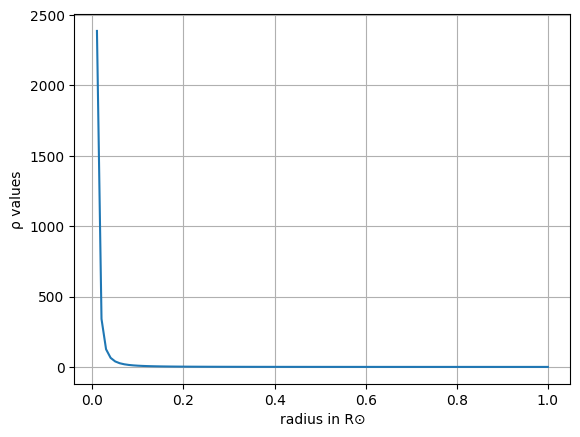

Converged in 76 iterations.
[0.001513 0.001917 0.002205 ... 0.011162 0.011517 0.012205]
Mean of the radius value for star with mass 𝑀⊙ in R⊙: 0.006633


In [95]:
print("Solution:")
sol = find_star_solution(100, 5/3,  print_rho=1)/(7e10 * (2e33 ** (1/3)))
print_vector(sol)
print("Mean of the radius value for star with mass 𝑀⊙ in R⊙:",
      f"{np.mean(sol):.6f}")

##### Explanation: 

We can see that the radius of the start with the same mass as sun will be ~0.006 of the radius of the Sun, as expected. Also we can see that most of the density is at the core, and it falls rapidly towards the outer edge. 

---

### Part 6: 

In [96]:
radiuses = np.zeros(6)
sol = np.zeros(100)
for i in range(1, 6):
    sol = find_star_solution(100, 5/3, i)/(7e10 * (2e33 ** (1/3)))
    print(f"Solution for mass {i} * 𝑀⊙: ")
    print_vector(sol)
    radiuses[i] = np.mean(sol)

for i in range(1, 6):
    rm_value = (radiuses[i]) * (i ** (1/3))
    print(f"RM^1/3 value for mass {i} * 𝑀⊙: {rm_value:.6f}")

Converged in 76 iterations.
Solution for mass 1 * 𝑀⊙: 
[0.001513 0.001917 0.002205 ... 0.011162 0.011517 0.012205]
Converged in 75 iterations.
Solution for mass 2 * 𝑀⊙: 
[0.001201 0.001522 0.001750 ... 0.008859 0.009141 0.009687]
Converged in 75 iterations.
Solution for mass 3 * 𝑀⊙: 
[0.001049 0.001329 0.001529 ... 0.007739 0.007986 0.008463]
Converged in 75 iterations.
Solution for mass 4 * 𝑀⊙: 
[0.000953 0.001208 0.001389 ... 0.007032 0.007255 0.007689]
Converged in 75 iterations.
Solution for mass 5 * 𝑀⊙: 
[0.000885 0.001121 0.001290 ... 0.006528 0.006735 0.007138]
RM^1/3 value for mass 1 * 𝑀⊙: 0.006633
RM^1/3 value for mass 2 * 𝑀⊙: 0.006633
RM^1/3 value for mass 3 * 𝑀⊙: 0.006633
RM^1/3 value for mass 4 * 𝑀⊙: 0.006633
RM^1/3 value for mass 5 * 𝑀⊙: 0.006633


##### Explanation: 

We can see that for different masses (1 to 5 of mass of the Sun) we still get the same $RM^{1/3} = 0.006$ value, as expected.

---

### Part 7: 

In [97]:
masses = [1.40, 1.41, 1.42, 1.43, 1.44, 1.45, 1.46]
radiuses = np.zeros(len(masses))
gamma = 4/3
sol = np.zeros(100)
for i in range(0, len(masses)):
    sol = find_star_solution(100, gamma, masses[i])/(7e10 * (2e33 ** (1/3)))
    print(f"Solution for mass {masses[i]} * 𝑀⊙: ")
    print_vector(sol)
    radiuses[i] = np.mean(sol)

for i in range(0, len(masses)):
    rm_value = radiuses[i]
    print(
        f"RM^1/3 value for mass {masses[i]} * 𝑀⊙: {(rm_value * (masses[i] ** (1/3))):.6f}")

ValueError: Unable to find a valid step to reduce the function value.

##### Explanation: 
I could not make it work with $\gamma = 4/3$, although I tried different intial conditions (for example those that are closer to the expected value) - somehow the function does not converge. As can be seen in the next part - the solution for $\gamma = 4/3$ is very unstable and depends largely on initial conditions - so even if in the other cases the function that I wrote did succed to find the values, here it did not work. Also I suspect that numerical Jacobian using 2 points and not proper analytical one may lead to this issue. 

---

### Part 8: 

In [98]:
def find_star_solution_with_scipy(n, gamma, m=1, r=1, initial_guess=None):
    if gamma == 5/3:
        kappa = 3.15 * 10**12
    elif gamma == 4/3:
        kappa = 4.9 * 10**14
    else:
        raise ValueError("The gamma value must be 5/3 or 4/3.")

    r_array = np.linspace(r/n, r, n)
    m_array = np.linspace(m/n, m, n)

    def f(x):
        return hydrostatic_function(m_array, x, kappa, gamma)

    def jacobian(x):
        return hydrostatic_jacobian(hydrostatic_function, m_array, x, kappa, gamma)

    if initial_guess is None:
        initial_guess = r_array.copy()

    # return fsolve(func=f, fprime=jacobian, x0=initial_guess)
    return root(fun=f, jac=jacobian, x0=initial_guess, method='lm')

In [99]:
# first star 
m = 1
print("Solution for star #1:")
sol1 = find_star_solution_with_scipy(100, 5/3, m, 1).x/(7e10 * (2e33 ** (1/3)))
print_vector(sol1)
print(np.mean(sol1) * (m**(1/3)))
print("\n")

# second star
m=1.42
print("Solution for star #2:")
sol2 = find_star_solution_with_scipy(
    100, 4/3, m, 1).x/(7e10 * (2e33 ** (1/3)))
print_vector(sol2)
print(np.mean(sol2) * (m**(1/3)))
print("\n")

Solution for star #1:
[0.001513 0.001917 0.002205 ... 0.011162 0.011517 0.012205]
0.0066325400576667005


Solution for star #2:
[0.000000 0.000000 0.000000 ... 0.000000 0.000000 0.000000]
4.2537581821031123e-20




##### Explanation: 
I used function scipy.optimize.root to find the solution instead of my Newton - Raphson function. For the first star i got the expected result: ~0.006 for value of $RM^{1/3}$. For the second function, the result was 0 - I think that the function is unable to find the solution for $\gamma = 4/3$ because it is very sensitive to the initial conditions. Maybe the probleme also lies in te fact that I used numerical and not analytical solution for Jacobian.